# Проект: Обучение с учителем: качество модели
___

# Описание исследования
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
___

# Цель исследования.
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
___

# Задачи исследования.
1. Промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по группам
   - Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
   - В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
   - Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
___   
   
# Исходные данные
Данные представлены в нескольких таблицах, а именно:
- `market_file.csv` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении
- `market_money.csv` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `market_time.csv` - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `money.csv` - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

## Загрузка данных <a id="bullet_1"></a>
### Загрузка необходимых библиотек <a id="bullet_1_1"></a>
Загрузим все библиотеки и функции, необходимые для данного исследования


In [1]:
pip install phik -q 

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install -U scikit-learn -q

In [3]:
!pip install shap -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.model_selection import train_test_split

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score

# импортируем используемые модели
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, make_scorer

# объявим константы
RANDOM_STATE = 22
TEST_SIZE = 0.25

### Загрузка исследуемых таблиц <a id="bullet_1_2"></a>

In [5]:
market = pd.read_csv('/datasets/market_file.csv')
    
print(market.info())
market.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


В данных не встретилось пропусков, а так же все типы данных столбцов соответствуют значениям в них.
___

In [6]:
market_money = pd.read_csv('/datasets/market_money.csv')
market.set_index('id', inplace=True)

print(market_money.info())
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Пропусков в данных снова не обнаружено, значения соответствуют типам данных. Однако можно увидеть, что данные записаны в неудобном формате. Есть строки с одинаковыми `id`, что будет неудобно в дальнейшем исследовании. Изменим таблицу для удобства использования.

In [7]:
market_money_pivot = market_money.pivot_table(index='id', columns='Период', values='Выручка')
market_money_pivot.head()

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


В таком формате данные будет использовать гораздо легче
___

In [8]:
market_time = pd.read_csv('/datasets/market_time.csv')

print(market_time.info())
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Пропусков в данных снова не обнаружено, значения соответствуют типам данных. В данных прослеживается та же проблема, что и в предыдущей таблице. Сделаем те же преобразования для её изменения.

In [9]:
market_time_pivot =market_time.pivot_table(index='id', columns='Период', values='минут')
market_time_pivot.head()

Период,предыдцщий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


Теперь данные представлены в более удобном формате
___

In [10]:
money = pd.read_csv('/datasets/money.csv', sep=';')
money.set_index('id', inplace=True)

print(money.info())
money.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Прибыль  1300 non-null   object
dtypes: object(1)
memory usage: 20.3+ KB
None


,Прибыль
id,
215348,"0,98"
215349,"4,16"
215350,"3,13"
215351,"4,87"
215352,"4,21"


В таблице `money` формат данных у столбца `Прибыль` не соответствует значениям столбца, формат данных нужно будет изменить.

Загруженные данные представляют собой четыре таблицы, в некоторых из которых есть столбцы с одинаковыми названиями, это нужно будет учесть в будущем, если возникнет необходимость объединять таблицы.

## Предобработка данных
### Исследование дубликатов

Для начала проверим количество полных дубликатов в первой загруженной таблице.

In [11]:
duplicated_index = market.index[market.duplicated()]
print(f'Количество полных дубликатов в таблице market: {market.duplicated().sum()}')

Количество полных дубликатов в таблице market: 11


Найдено целых 11 полных дубликатов. Шанс того, что все такое количество параметров у двух пользователей хоть и вероятно, но очень подозрительно.

### Изменение формата столбцов

Изменим тип данных столбца `Прибыль` в таблице `money` с формата object на float. Произошла ошибка из-за того, что разделитем дробной части была запятая, а не точка. Поэтому формат данных не соответсвовал ожидаемому.

In [12]:
money['Прибыль'] = money['Прибыль'].str.replace(',', '.')
money['Прибыль'] = money['Прибыль'].astype('float')
money.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Прибыль  1300 non-null   float64
dtypes: float64(1)
memory usage: 20.3 KB


### Изменение названия столбоцов

Во многих столбцах можно встретить названия, которые не соответсвуют общепринятым требованиям, или же в названиях иногда встречаются опечатки. Поэтому переименуем все столбцы в таблицах `market` и `market_money_pivot`(В остальных таблицах ошибок в написании названий нет)

In [13]:
market.columns = ['Покупательская_активность',
                 'Тип_сервиса',
                 'Разрешить_сообщать',
                 'Маркет_актив_6_мес',
                 'Маркет_актив_тек_мес',
                 'Длительность',
                 'Акционные_покупки',
                 'Популярная_категория',
                 'Средний_просмотр_категорий_за_визит',
                 'Неоплаченные_продукты_штук_квартал',
                 'Ошибка_сервиса',
                 'Страниц_за_визит']


market_money_pivot.columns = ['предыдущий_месяц',
                             'предпредыдущий_месяц',
                             'текущий_месяц']

market_time_pivot.columns = ['предыдущий_месяц',
                            'текущий_месяц']

***Выводы***

## Исследовательский анализ данных
### Общий анализ признаков

Для начала выведем общую информацию всех таблиц, и проанализируем их.

In [14]:
market.describe()

,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


В данных аномалии не прослеживаются.

In [15]:
market_money_pivot.describe()

,предыдущий_месяц,предпредыдущий_месяц,текущий_месяц
count,1300.000000,1300.000000,1300.000000
mean,4936.920385,4825.206923,5314.960846
std,739.597997,405.979663,2939.708156
min,0.000000,0.000000,2758.700000
25%,4496.750000,4583.000000,4706.050000
50%,5005.000000,4809.000000,5179.950000
75%,5405.625000,5053.500000,5761.725000
max,6869.500000,5663.000000,106862.200000


В столбце `текущий_месяц` необычно большое максимальное значение. Исследуем эти данные подробнее.

Text(0, 0.5, 'Количество покупоателей')

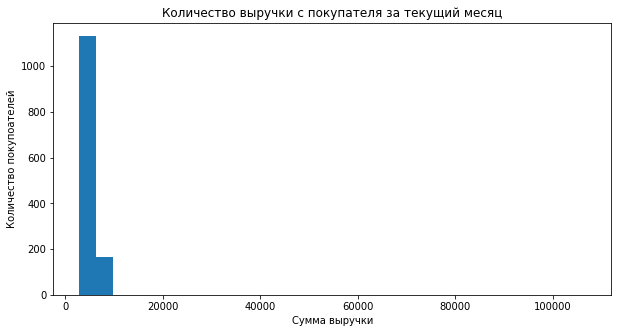

In [16]:
ax = market_money_pivot['текущий_месяц'].plot(kind='hist',
                                              bins=30,
                                              title='Количество выручки с покупателя за текущий месяц',
                                              figsize=(10, 5)
                                             )
ax.set_xlabel('Сумма выручки')
ax.set_ylabel('Количество покупоателей')

Можно заметить, что количество выручки покупателей более 20000 практически не встречается на гистограмме (таких случаев практически нет). Проверим сколько таких строк есть в таблице.

In [17]:
high_index = market_money_pivot.index[market_money_pivot['текущий_месяц'] > 20000]
high_index

Int64Index([215380], dtype='int64', name='id')

Такая строка всего одна, поэтому можем смело её удалить. Так как во всех таблицах встречаются данные с одинаковыми индексами, то удалим эту строку из всех таблиц сразу.

In [18]:
table_list = [market, market_time_pivot, market_money_pivot, money]

for data in table_list:
    data.drop(high_index, inplace=True)

Text(0, 0.5, 'Количество покупоателей')

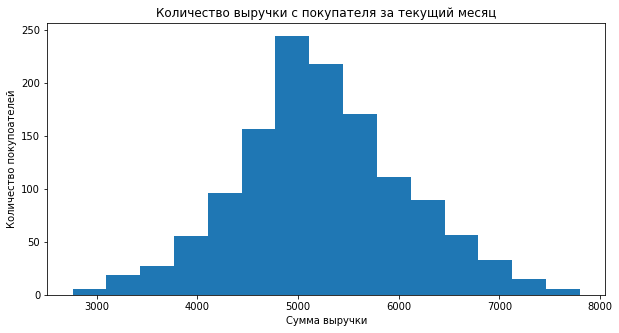

In [19]:
ax = market_money_pivot['текущий_месяц'].plot(kind='hist',
                                              bins=15,
                                              title='Количество выручки с покупателя за текущий месяц',
                                              figsize=(10, 5)
                                             )
ax.set_xlabel('Сумма выручки')
ax.set_ylabel('Количество покупоателей')

In [20]:
market_time_pivot.describe()

,предыдущий_месяц,текущий_месяц
count,1299.000000,1299.000000
mean,13.468822,13.204003
std,3.933332,4.222157
min,5.000000,4.000000
25%,11.000000,10.000000
50%,13.000000,13.000000
75%,17.000000,16.000000
max,23.000000,23.000000


Данные выглядят правдоподобно

In [21]:
money.describe()

,Прибыль
count,1299.000000
mean,3.996721
std,1.014107
min,0.860000
25%,3.300000
50%,4.050000
75%,4.670000
max,7.430000


Данные выглядят правдоподобно, аномалии не выявлены.

### Подробный анализ признаков.

#### Анализ количественных величин
##### Таблица `market`

Исследуем каждую количественную категорию отдельно. Для начала начнем анализ с помощью гисторамм и диаграмм размаха. Для их построения напишем отдельную функцию и начнем анализ.

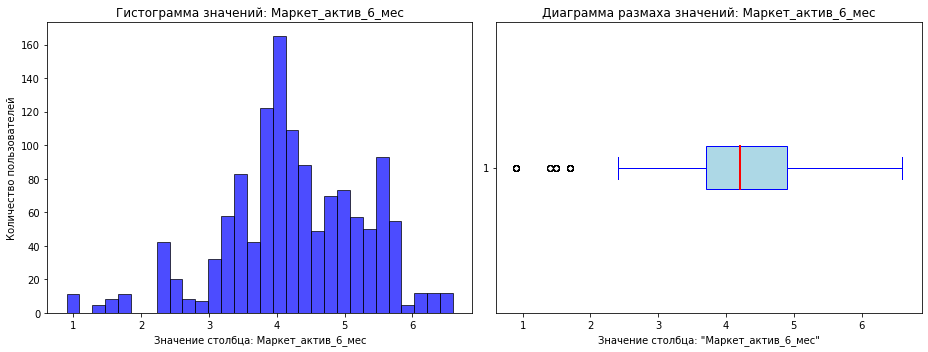

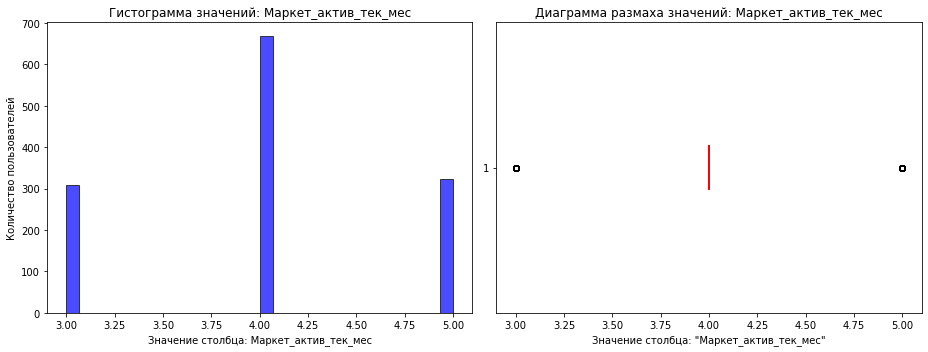

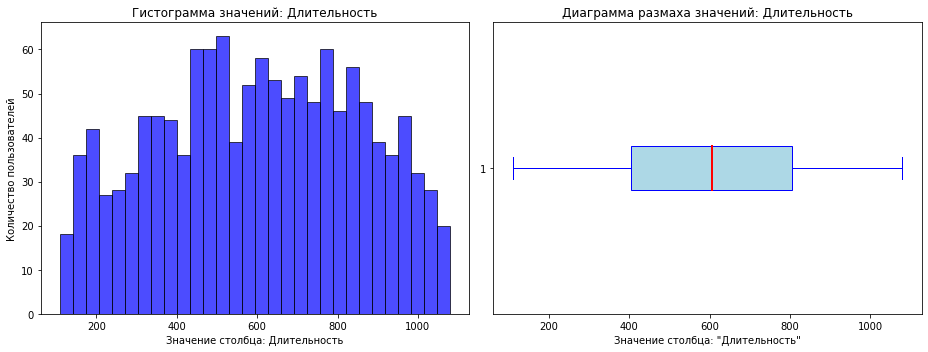

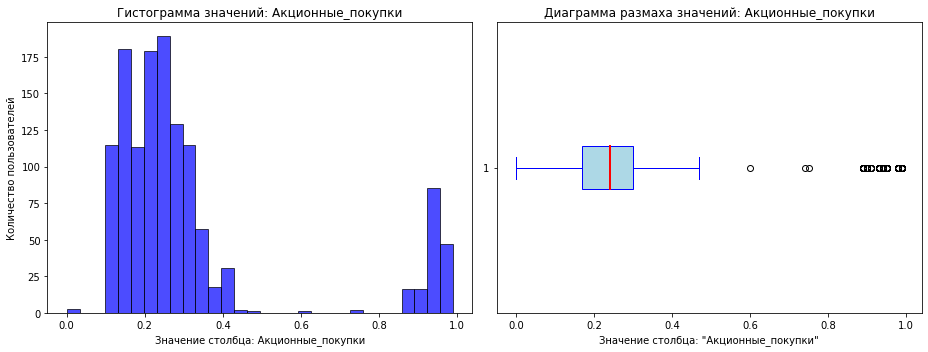

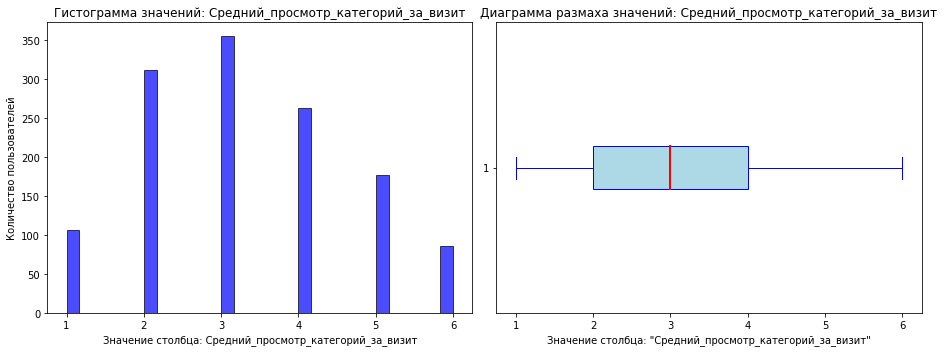

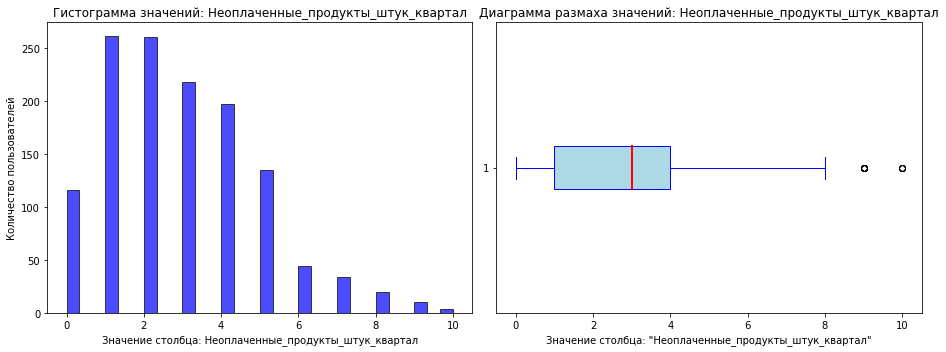

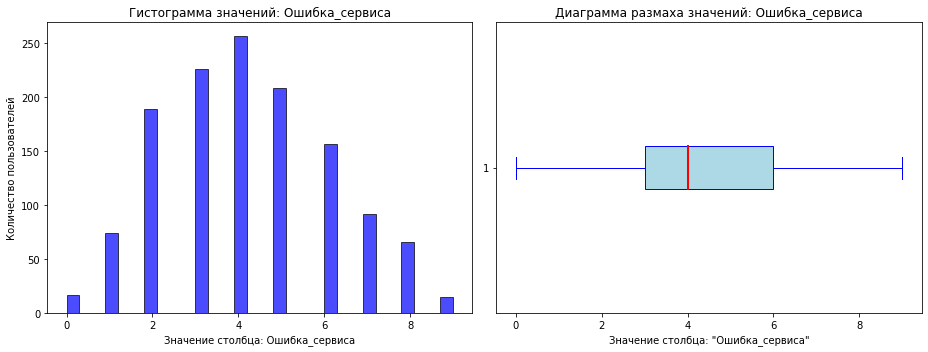

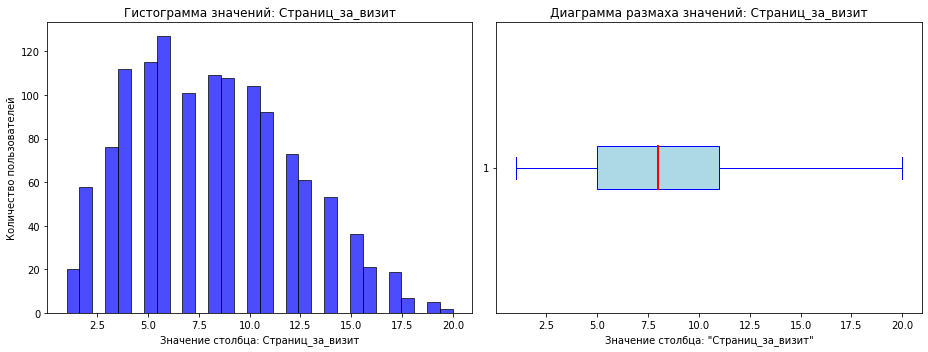

In [22]:
def hist_boxplot(column):  # Функция для построения гистограмм и диаграмм размаха
    plt.figure(figsize=(13, 5))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    plt.title(f'Гистограмма значений: {column.name}')
    plt.xlabel(f'Значение столбца: {column.name}')
    plt.ylabel('Количество пользователей')
    plt.hist(column, bins=30, color='blue', edgecolor='black', alpha=0.7)
    
    # Диаграмма размаха
    plt.subplot(1, 2, 2)
    plt.title(f'Диаграмма размаха значений: {column.name}')
    plt.boxplot(column, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='blue'),
                capprops=dict(color='blue'))
    plt.xlabel(f'Значение столбца: "{column.name}"')

    plt.tight_layout()
    plt.show()
    

# Список числовых колонок
market_num_columns = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит'
]

# Построение графиков для каждого столбца
for column in market_num_columns:
    hist_boxplot(market[column])
    

***Выводы по анализу численных признаков данных***
1. Маркет_актив\_6_мес

    * Есть небольшое количество выбросов данных с малыми значениями, скорее всего придётся избавится от этих значений
    
    
2. Маркет_актив_тек_мес
    
    * Данные оказались разделены на три столбца, выделилось всего три значения


3. Длительность

    * Аномалий в данных не выявлено
    
    
4. Акционные_покупки

    * В данных прослеживается малочисленная группа данных, значения которых выбиваются из общей картины
    * Возможно данные из этого столбца придется перевести в категориальные данные
    
    
5. Средний_просмотр_категорий_за_визит

    * Аномалий в данных не выявлено
    
    
6. Неоплаченные_продукты_штук_квартал

    * Есть небольшое количество выбросов, которые будут рассмотрены позже
    
    
7. Ошибка_сервиса

    * Аномалий в данных не выявлено
    
    
8. Страниц_за_визит

    * Аномалий в данных не выявлено

**Маркет_актив\_6_мес**


Посмотрим на количество строк столбца `Маркет_актив_6_мес`, значения которых меньше двух

In [23]:
drop_index = market.loc[market['Маркет_актив_6_мес'] < 2, 'Маркет_актив_6_мес'].index
print(f'Количество строк, значения которых менее 2: {len(drop_index)}')

Количество строк, значения которых менее 2: 35


**Неоплаченные_продукты_штук_квартал**

Посмотрим на количество строк столбца Маркет_актив_6_мес, значения которых больше восьми

In [24]:
drop_index = market.loc[market['Неоплаченные_продукты_штук_квартал'] > 8, 'Неоплаченные_продукты_штук_квартал'].index
print(f'Количество строк, значения которых более 8: {len(drop_index)}')

Количество строк, значения которых более 8: 14


**Маркет_актив_тек_мес**

В исследовании данные разделились на три столбца, посмотри на уникальные значения в этом столбце

In [25]:
market['Маркет_актив_тек_мес'].unique()

array([5, 4, 3])

Количество уникальных значений равно трем, поэтому будем рассматривать этот столбец как категориальный далее в исследовании.

**Акционные_покупки**

Данные в исследовании разделились на две группы, одна из которых немногочисленная. Посмотрим на количество строк в немногочисленной группе. (Разделение двух групп наблюдается на значении примерно 0,7)

In [26]:
drop_index = market.loc[market['Акционные_покупки'] > 0.7, 'Неоплаченные_продукты_штук_квартал'].index
print(f'Количество строк, значения которых более 0.7: {len(drop_index)}')

Количество строк, значения которых более 0.7: 166


Значени всего 144. Этого довольно много, чтобы удалять их из таблиц, но довольно мало чтобы заносить их в отдельную категорию. Тем более есть вполне рациональное объяснение таких покупателей - некоторые действительно следят за скидками и акциями, и делают покупки только по сниженнойй цене.

Исходя из всего вышескзаанного - принимается решение оставить данные в том же виде.

##### Оставшиеся таблицы

Проведем анализ количественных признаков оставшихся таблиц.

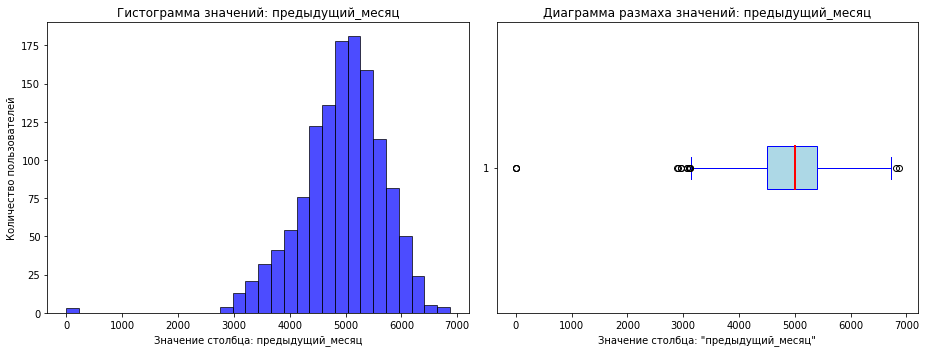

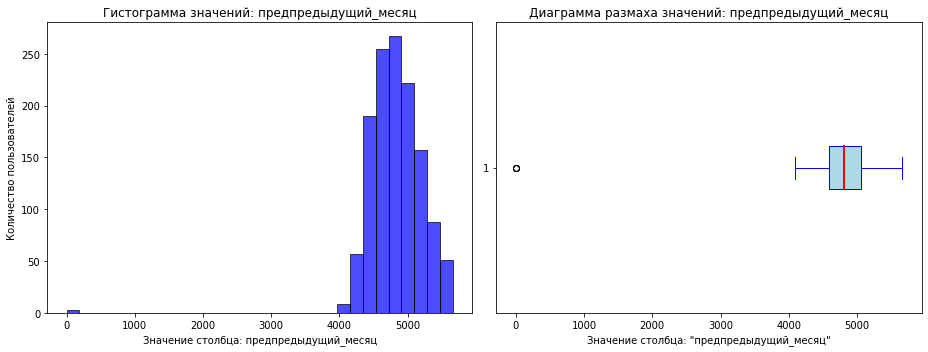

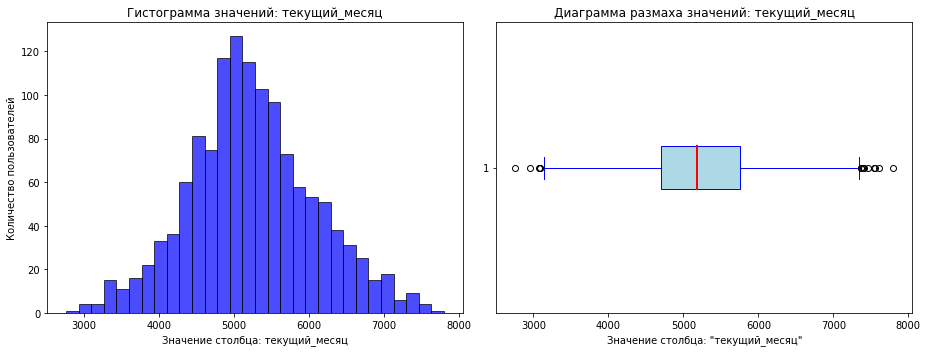

In [27]:
market_money_pivot_num_columns = ['предыдущий_месяц',
                                 'предпредыдущий_месяц',
                                 'текущий_месяц']

market_time_pivot_num_columns = ['предыдущий_месяц',
                                'текущий_месяц']

money_num_columns = ['Прибыль']

for columns in market_money_pivot_num_columns:
    hist_boxplot(market_money_pivot[columns])

***Выводы***

**предыдущий_месяц**

    - Есть небольшие выбросы данных, которые находятся рядом с 'усами'. так как отклонение крайне невилеко - оставим данные в прежнем виде
    - Есть выброс нулевых значений, что легко объясняется отсутсвием покупок клиентов в эти месяцы. Так как эти клиенты могли совершить покупки в другие месяцы - оставим данные в прежнем виде
    
   
**предпредыдущий_месяц**

    - Есть выброс нулевых значений, что легко объясняется отсутсвием покупок клиентов в эти месяцы. Так как эти клиенты могли совершить покупки в другие месяцы - оставим данные в прежнем виде
    

**текущий_месяц**

    - Можно пронаблюдать выбросы данных как в верхнюю, так и в нижнюю сторону. Однако это первый месяц, в котором отсутствуют нулевые значения, поэтому незначительные выбросы можно объяснить резким наплывом клиентов. Из-зи этого оставим данные в прежнем виде

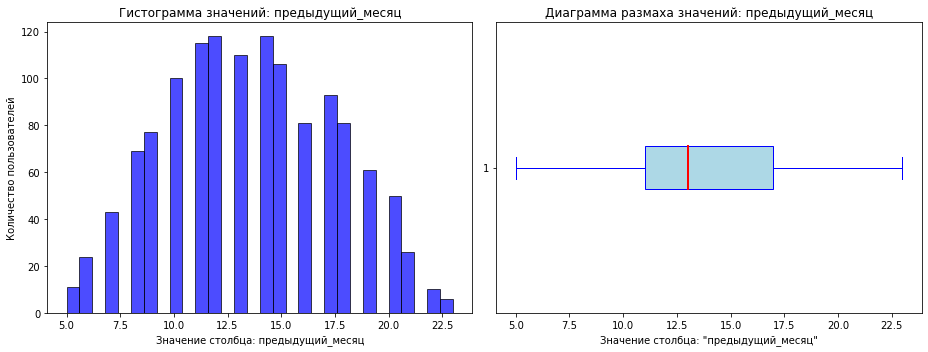

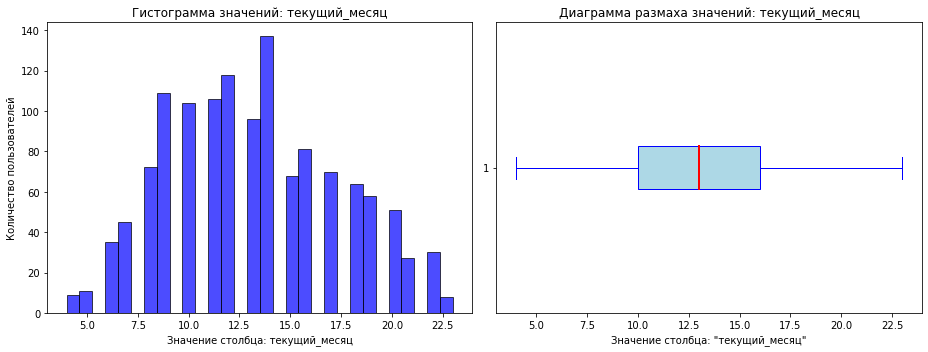

In [28]:
for columns in market_time_pivot_num_columns:
    hist_boxplot(market_time_pivot[columns])

***Выводы***

**предыдцщий_месяц**

    - Аномалии в данных не обнаружены
    

**текущий_месяц**

    - Аномалии в данных не обнаружены

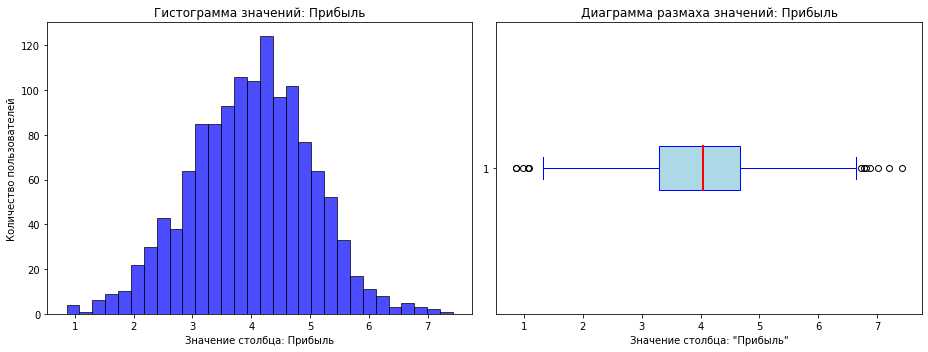

In [29]:
for columns in money_num_columns:
    hist_boxplot(money[columns])

***Выводы***

- Наблюдаются выбросы значений с обеих сторон. Проверим количество клиентов, которые приносят очень много или очень мало прибыли, и по возможности избавимся от этих данных.

In [30]:
drop_index = money[(money['Прибыль'] > 6.8) | (money['Прибыль'] < 1.3)].index
print(f'Количество аномальных значений: {len(drop_index)}')

Количество аномальных значений: 10


#### Анализ категориальных данных

Для анализа категориальных признаков напишем функцию, которая будет визуализировать значения признаков. Заметим, что такие признаки остались только в таблице `market`

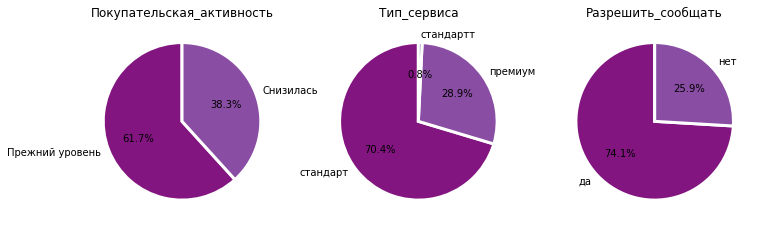

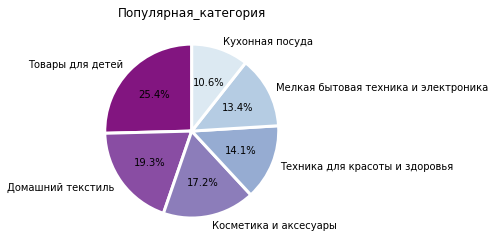

In [31]:
def pie_features(data, column_name, rows, columns, i):
    plt.subplot(rows, columns, i)
    plt.title(column_name)
    plt.pie(x=data[column_name].value_counts(),
            startangle=90,
            wedgeprops={'linewidth':3, 'edgecolor':'white'}, 
            autopct='%1.1f%%',
            labels=data[column_name].value_counts().index, 
            colors=sns.color_palette('BuPu_r')
           )
    
    
market_cat_columns_first = ['Покупательская_активность', # разделение нужно для того чтобы графики в нормальных пропорциях поместились на выходе
                     'Тип_сервиса',
                     'Разрешить_сообщать'
                     ]

market_cat_columns_second = [
                     'Популярная_категория',
                     ]


plt.figure(figsize=(12, 10))
i = 1
for column_name in market_cat_columns_first:
    pie_features(market, column_name, len(market_cat_columns_first), i)
    i = i + 1
plt.show()

plt.figure(figsize=(4, 4))
i = 1
for column_name in market_cat_columns_second:
    pie_features(market, column_name, len(market_cat_columns_second), i)
    i = i + 1    


***Выводы***

**Покупательская_активность**

    - Аномалий в данных не выявлено
 
 
**Тип_сервиса**

    - Обнаружена группа данных, под названием "стандартт", которая занимает всего 0.8% данных. Очевидно что такое название произошло из-за ошибки в названии "стандарт". Данную ошибку нужно будет исправить.
 

**Разрешить_сообщать**

    - Аномалий в данных не обнаружнено
    
    
**Маркет_актив_тек_мес**

    - Аномалий в данных не обнаружено
    

**Популярная_категория**

    - Аномалий в данных не обнаружено
    


**Тип_сервиса**

Исправим все значения "стандартт" на "стандарт"

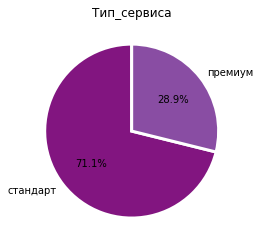

In [32]:
market['Тип_сервиса'] = market['Тип_сервиса'].replace('стандартт', 'стандарт')

pie_features(market, 'Тип_сервиса', 1, 1)

### Отбор активных покупателей

Выделим покупателей, которые совершали покупки за последние три месяца в отдельный датасет. Сделать это мы можем по таблице `market_money_pivot`.

In [33]:
inactive_customers_index = market_money_pivot[(market_money_pivot == 0).any(axis=1)].index
print(f'Количество неактивных пользователей за последние три месяца: {len(inactive_customers_index)}')

Количество неактивных пользователей за последние три месяца: 3


Пользователей, не совершивших покупку хотя бы в один из трех месяцев всего двое. Удалим их из основного датасета, сохранять в отдельный датасет информацию с ними не будем, так как значения всего два - что сильно не повлияет на работу модели.

In [34]:
print(f'Количество строк в таблице до удаления аномалий {market.shape[0]}')

for data in table_list:
    data.drop(inactive_customers_index, inplace=True)
    
print(f'Количество строк в таблице после удаления аномалий {market.shape[0]}')

Количество строк в таблице до удаления аномалий 1299
Количество строк в таблице после удаления аномалий 1296


## Объединение таблиц

Для объединения таблиц еще раз переименуем столбцы в таблицах `market_money_pivot` и `market_time_pivot`. Это нужно сделать для того, чтобы одинаковые названия столбцов не были перепутаны друг с другом

In [35]:
market_money_pivot.columns = ['предыдущий_месяц_выручка',
                              'предпредыдущий_месяц_выручка',
                              'текущий_месяц_выручка'
                             ]

market_time_pivot.columns = ['предыдущий_месяц_минуты',
                            'текущий_месяц_минуты'
                            ]

Теперь приступим к объединению таблиц в одну таблицу под названием `full_market`

In [36]:
rows_count = market['Покупательская_активность'].count()
print(f'Количество строк в начальном датафрейме: {rows_count}')

full_market = market

full_market = pd.merge(full_market, market_money_pivot, left_index=True, right_index=True)
full_market = pd.merge(full_market, market_time_pivot, left_index=True, right_index=True)

rows_count = market['Покупательская_активность'].count()
print(f'Количество строк в итоговом датафрейме: {rows_count}')

full_market.head()

Количество строк в начальном датафрейме: 1296
Количество строк в итоговом датафрейме: 1296


,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,предпредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


Количетво строк после объединения не изменилось. Значит все строки объединились корректно.

## Корреляционный анализ

Проведем корреляционный анализ количественных признаков

Text(0.5, 1.0, 'Корреляционная таблица для всего датафрейма')

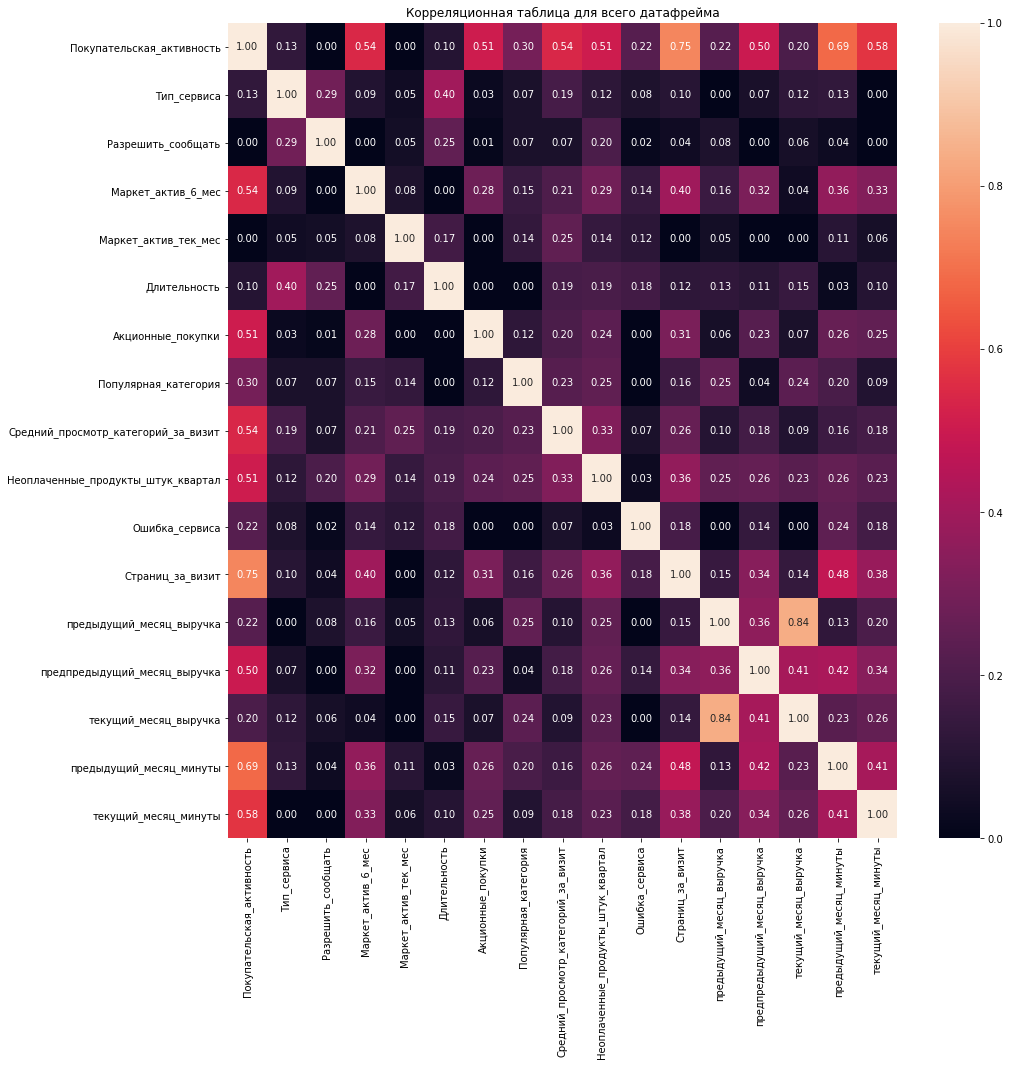

In [37]:
interval_cols = ['Маркет_актив_6_мес',
                'Маркет_актив_тек_мес',
                'Длительность',
                'Акционные_покупки',
                'Средний_просмотр_категорий_за_визит',
                'Неоплаченные_продукты_штук_квартал',
                'Ошибка_сервиса',
                'Страниц_за_визит',
                'предыдущий_месяц_выручка',
                'предпредыдущий_месяц_выручка',
                'текущий_месяц_выручка',
                'предыдущий_месяц_минуты',
                'текущий_месяц_минуты'
                ]

phik_matrix = full_market.phik_matrix(interval_cols=interval_cols)

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', ax=ax)
ax.set_title('Корреляционная таблица для всего датафрейма')

Значения коэфициентов корреляции с целевым признаком не превышают 0,9 - следовательности мультиколлинеарности с целевым признаком нет. Также среди остальных данных не наблюдается таких высоких значений коэффициентов корреляции - значит мультиколлинеарности среди признаков нет.

Так же рассмотрим отдельно таблицы корреляции для каждого класса целевого признака, для того чтобы постараться узнать дополнительную информацию о данных.

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


Text(0.5, 1.0, 'Корреляционная таблица для датафрейма со сниженной покупательской активностью')

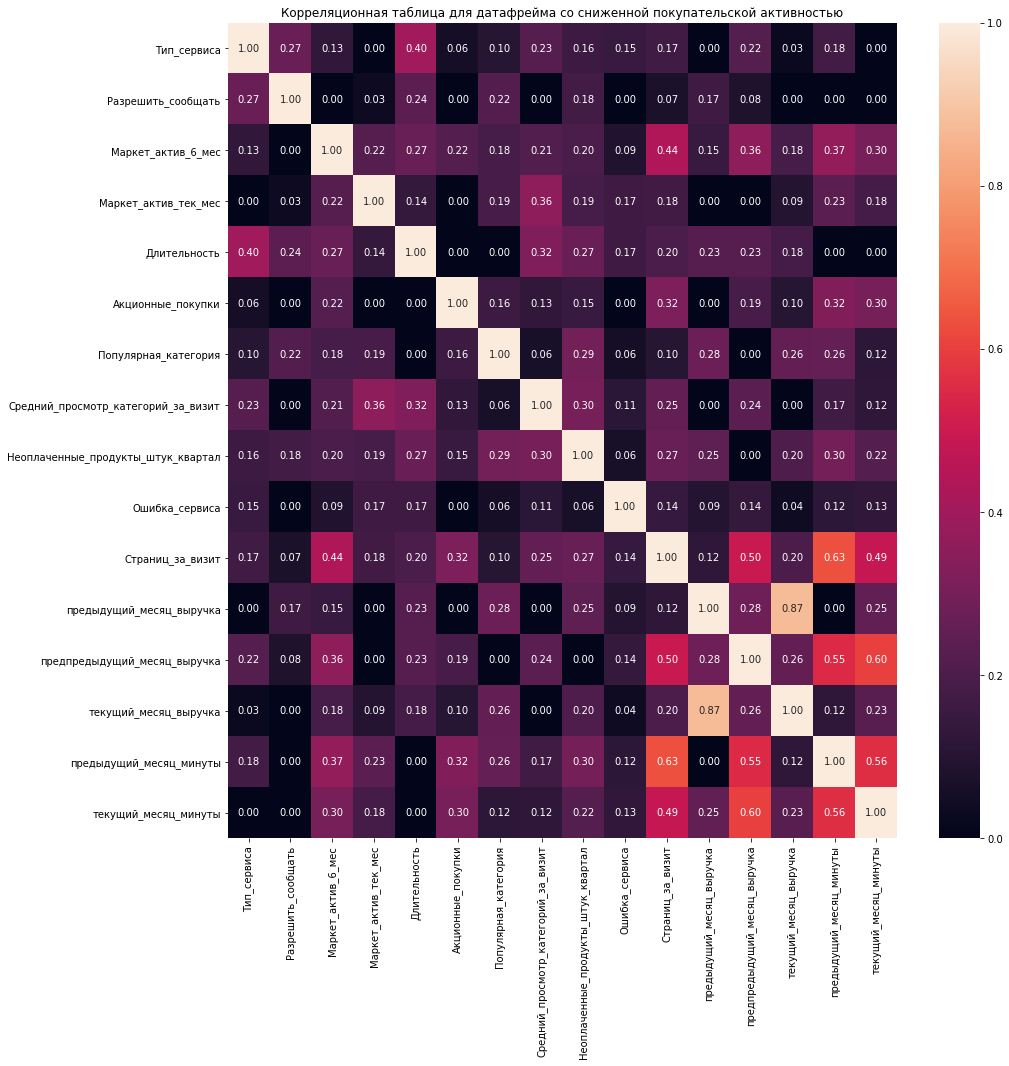

In [38]:
decreased_full_market = full_market[full_market['Покупательская_активность'] == 'Снизилась']

phik_matrix = decreased_full_market.phik_matrix(interval_cols=interval_cols)

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', ax=ax)
ax.set_title('Корреляционная таблица для датафрейма со сниженной покупательской активностью')

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Покупательская_активность for analysis 1. Dropping this column
  warnings.warn(


Text(0.5, 1.0, 'Корреляционная таблица для датафрейма со прежней покупательской активностью')

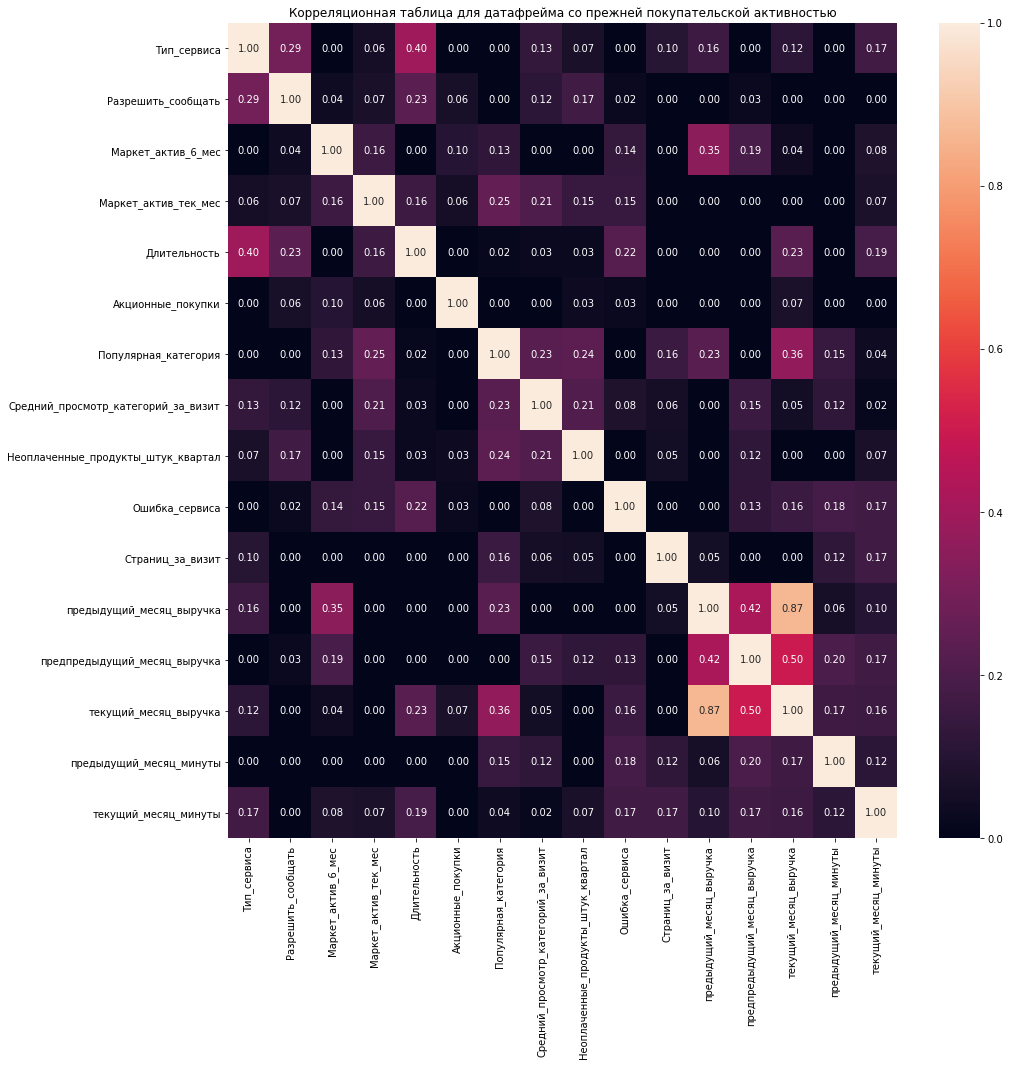

In [39]:
remaind_full_market = full_market.drop(decreased_full_market.index)

phik_matrix = remaind_full_market.phik_matrix(interval_cols=interval_cols)

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', ax=ax)
ax.set_title('Корреляционная таблица для датафрейма со прежней покупательской активностью')

При анализе каждого из классов отдельно не было обнаружено сильное отклонение значений коэффициентов корреляции - аномалий или новых взаимосвязей в данных не обнаружено.

## Использование пайплайнов
### Масштабирование и кодирование признаков

Разделим признаки на две группы, для разных целей:

- Масштабирование данных
- Кодирование данных с помощью `OneHotEncoder`

In [40]:
original_classes = ['Снизилась', 'Прежний уровень']


le_custom = LabelEncoder()

le_custom.fit(original_classes)  

full_market['Покупательская_активность'] = le_custom.transform(full_market['Покупательская_активность'])

num_columns = [
    'Маркет_актив_6_мес',
    'Маркет_актив_тек_мес',
    'Маркет_актив_тек_мес',
    'Длительность',
    'Акционные_покупки',
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'предыдущий_месяц_выручка',
    'предпредыдущий_месяц_выручка',
    'текущий_месяц_выручка',
    'предыдущий_месяц_минуты',
    'текущий_месяц_минуты'
]

ohe_columns = [
    'Тип_сервиса',
    'Разрешить_сообщать'
]

ord_columns = [
    'Популярная_категория'
]

Создадим пайплайн для подготовки данных

In [41]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False), ohe_columns),
        ('num', StandardScaler(), num_columns), 
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
        ),
        ord_columns)
    ],
    remainder='passthrough' 
)

### Создание полного пайплайна и словаря с параметрами

Создадим пайплайн, который будет перебирать несколько алгоритмов масштабирования:

- `StandardScaler`
- `MinMaxScaler`
- `RobustScaler`

А так же с перебором нескольких моделей:

- `DecisionTreeClassifier`
- `KNeighborsClassifier`
- `LogisticRegression`
- `SVC`

Для корректного перебора параметров пайплайнов создадим словарь, со всеми нужными параметрами для перебора

In [42]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': ['auto', 'log2', *range(2, 12)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga')],
        'models__penalty': ['l1', 'l2', 'elasticnet'],
        'models__l1_ratio': np.linspace(0, 1, 5),  # Для elasticnet
        'models__C': np.logspace(-4, 4, 20),
        'models__class_weight': [None, 'balanced'],
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf', 'poly'],
        'models__C': [0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    }
]

### Поиск лучшей модели

Найдем лучшую модель для дальнейшего её изучения. Для нахождения лучшей модели выберем метрику `recall`, поскольку она отвечает за способоность модели найти все положительные примеры в данных, то есть найти всех клиентов, у которых снизилась покупательская активность. Если модель определит клиента с обычной активностью, и определит его в тех, у кого она снизилась - компания будет стараться привлечь его к себе сильнее, что может повысить его активность и принести прибыль.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    full_market.drop(['Покупательская_активность'], axis=1),
    full_market['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE
)

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='recall',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать']),
                                                 ('num', StandardScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Длительность',
                                                   'Акционные_покупки',
                                                   'Средний_просмотр_категор

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/

Лучшей оказалась модель LogisticRegression со следующими параметрами

- C=10000
- class_weight='balanced' 
- l1_ratio=0.25 
- solver='saga' 

## Анализ важности признаков
### Визуализация важности признаков

С помощью графиков визуализируем важность признаков, которые использует лучшая модель

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


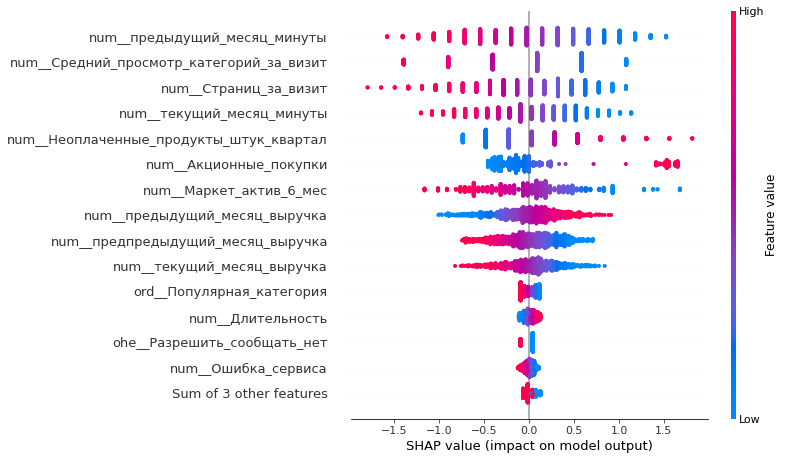

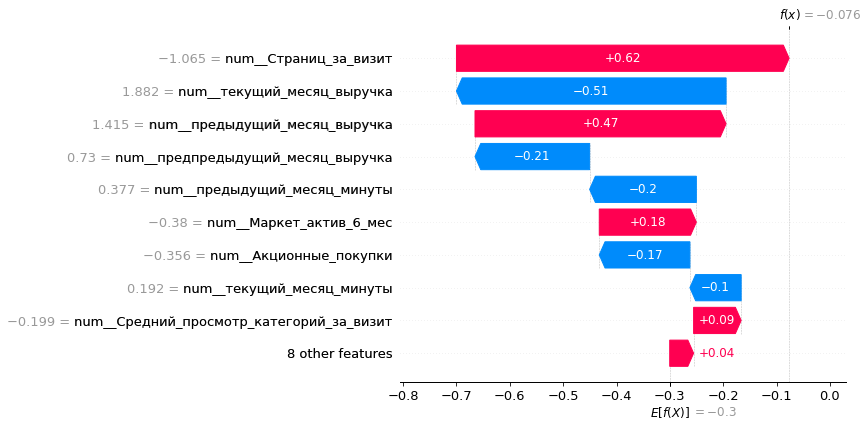

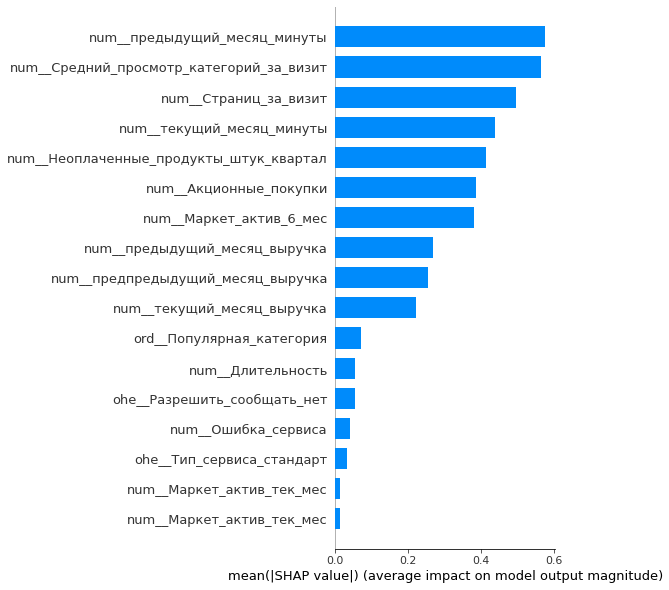

In [44]:
best_pipeline = Pipeline(steps=[
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(C=10000.0, class_weight='balanced', l1_ratio=0.25, random_state=22, solver='saga'))
])

best_pipeline.fit(X_train, y_train)

# Преобразование данных
X_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)


feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()



explainer = shap.Explainer(best_pipeline.named_steps['models'], X_transformed, feature_names=feature_names)
shap_values = explainer(X_transformed)


shap.plots.beeswarm(shap_values, max_display=15)


shap.plots.waterfall(shap_values[0])

shap.summary_plot(shap_values, plot_type='bar') 

Перед анализом полученных результатов нужно напомнить, что целевой признак "Покупательская_активность" -> "Снизилась" - закодирован еденицей.

Из получившихся результатов можно огласить следующие выводы:

**Выводы:**

- *Малозначительные признаки*

    - Меньше всего на модель влияют признаки, которые описывают маркетинговую активность - значит маркетинговая стратегия малоэффективная и не практически не влияет на покупательсую активность\
    - Признаки, которые связаны с технической часть сервиса, а именно - `Тип_сервиса`, `Ошибка_сервиса`, `Разрешить_сообщать`, `Длительность`. Эти признаки практически никак не связаны с покупательской активностью клиента
    - `Популярная_категория` - тоже оказалась малозначимым признаком, что означает отсутствеи перевеса популярности какой-либо из категорий на платформе
    
    
- *Признаки, сильновлияющие на модель:*

    - Больше всего на модель влияют признаки, отвечающие за количество времени, которое клиент потратил на сайте, такие как `предыдущий_месяц_минуты`, `Средний_просмотр_категорий_за_визит`, `Страниц_за_визит`, `текущий_месяц_минуты`. При чем чем дольше клиент находится на сайте, тем больше вероятность что он что-нибудь купит.
    - Чем больше клиент покупает товаров по акции, или чем больше у него неоплаченных товаров, тем больше вероятность что покупательская активность клиента снизиться.
    - На модель сильно влияют показатели выручки, рассмотрим отдельно выручку за каждый предоставленный период:
        - `текущий_месяц_минуты` - если показатель выручки высок в текущем месяце, то покупательская активность с большой вероятностью не будет снижена. Это можно объяснить тем, что если клиент покупает товары в этом месяце, то он уже проявляет активность, и значит она вряд ли снизится в сравнении с другими месяцами
        - `предыдущий_месяц_минуты` - чем больше показатель выручки за предыдущий месяц - тем больше шанс что актисность снизиться.  Возможнно это происходит из-за того клиенты купили много товаров в предыдущем месяце, а в текущем те же товары им пока не требуется, из-за этого и покупательская активность будет снижена
        - `предпредыдущий_месяц_выручка`  - чем больше значение - тем меньше вероятность снижения активности


***Общие выводы***

- Требуется поменять используемую маркетинговую стратегию, так как она мало влияет на покупательскую активность в данный момент
- Следует делать упор маркетингвых предложений для клиентов, которые купили много товаров в предыдущем месяце. Нужно это для того, чтобы их покупательская активность не снижалась
- Постараться завлекать клиентов, которые покупают товары только по скидке

In [45]:
full_market.head()

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,предпредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_минуты,текущий_месяц_минуты
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


## Шаг 8. Сегментация покупателей
### Проведем сегментацию покупателей по целевому признаку
Отберем отдельный сегмент покупателей, в которых модель будет уверена, что покупательская активность будет снижена. Так же добавим к этим данным столбец 'Порог' со значением высокий, чтобы потом сравнить эти данные с другим сегментом

In [46]:
predictions = best_pipeline.predict_proba(full_market.drop(['Покупательская_активность'], axis=1))[:, 1]

prediction_flags = np.where(predictions > 0.9, True, False)

segment_market_threshold_high = full_market[prediction_flags]

segment_market_threshold_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 215349 to 215932
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            283 non-null    int64  
 1   Тип_сервиса                          283 non-null    object 
 2   Разрешить_сообщать                   283 non-null    object 
 3   Маркет_актив_6_мес                   283 non-null    float64
 4   Маркет_актив_тек_мес                 283 non-null    int64  
 5   Длительность                         283 non-null    int64  
 6   Акционные_покупки                    283 non-null    float64
 7   Популярная_категория                 283 non-null    object 
 8   Средний_просмотр_категорий_за_визит  283 non-null    int64  
 9   Неоплаченные_продукты_штук_квартал   283 non-null    int64  
 10  Ошибка_сервиса                       283 non-null    int64  
 11  Страниц_за_визит        

Так же добавим к этим данным информацию о прибыли каждого из клиентов.

In [47]:
segment_market_threshold_high = segment_market_threshold_high.join(money, on='id')

segment_market_threshold_high['Порог'] = 'Высокий'

segment_market_threshold_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 215349 to 215932
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            283 non-null    int64  
 1   Тип_сервиса                          283 non-null    object 
 2   Разрешить_сообщать                   283 non-null    object 
 3   Маркет_актив_6_мес                   283 non-null    float64
 4   Маркет_актив_тек_мес                 283 non-null    int64  
 5   Длительность                         283 non-null    int64  
 6   Акционные_покупки                    283 non-null    float64
 7   Популярная_категория                 283 non-null    object 
 8   Средний_просмотр_категорий_за_визит  283 non-null    int64  
 9   Неоплаченные_продукты_штук_квартал   283 non-null    int64  
 10  Ошибка_сервиса                       283 non-null    int64  
 11  Страниц_за_визит        

Создадим еще один сегмент клиентов, только у которых на этот раз покупательская активность не снижалась. Проведем те же действия.

In [50]:
predictions = best_pipeline.predict_proba(full_market.drop(['Покупательская_активность'], axis=1))[:, 1]

prediction_flags = np.where(predictions < 0.1, True, False)

segment_market_threshold_low = full_market[prediction_flags]

segment_market_threshold_low = segment_market_threshold_low.join(money, on='id')

segment_market_threshold_low['Порог'] = 'Низкий'

segment_market_threshold_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 215681 to 216644
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            306 non-null    int64  
 1   Тип_сервиса                          306 non-null    object 
 2   Разрешить_сообщать                   306 non-null    object 
 3   Маркет_актив_6_мес                   306 non-null    float64
 4   Маркет_актив_тек_мес                 306 non-null    int64  
 5   Длительность                         306 non-null    int64  
 6   Акционные_покупки                    306 non-null    float64
 7   Популярная_категория                 306 non-null    object 
 8   Средний_просмотр_категорий_за_визит  306 non-null    int64  
 9   Неоплаченные_продукты_штук_квартал   306 non-null    int64  
 10  Ошибка_сервиса                       306 non-null    int64  
 11  Страниц_за_визит        

In [51]:
segment_market = pd.concat([segment_market_threshold_high, segment_market_threshold_low], ignore_index=True)

segment_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская_активность            589 non-null    int64  
 1   Тип_сервиса                          589 non-null    object 
 2   Разрешить_сообщать                   589 non-null    object 
 3   Маркет_актив_6_мес                   589 non-null    float64
 4   Маркет_актив_тек_мес                 589 non-null    int64  
 5   Длительность                         589 non-null    int64  
 6   Акционные_покупки                    589 non-null    float64
 7   Популярная_категория                 589 non-null    object 
 8   Средний_просмотр_категорий_за_визит  589 non-null    int64  
 9   Неоплаченные_продукты_штук_квартал   589 non-null    int64  
 10  Ошибка_сервиса                       589 non-null    int64  
 11  Страниц_за_визит                

### Сегментация по самым значимым признакам

Возьмем признаки с самой высокой значимостью, которые были найдены в предыдущем пункте и исследуем их подробнее для каждого из сегментов.

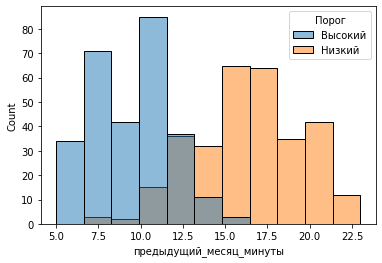

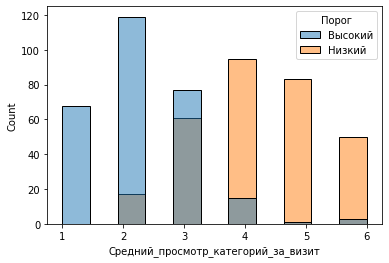

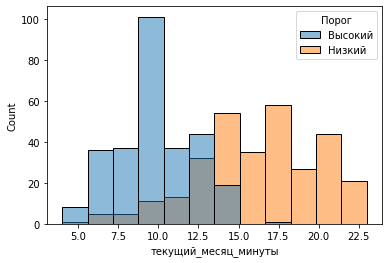

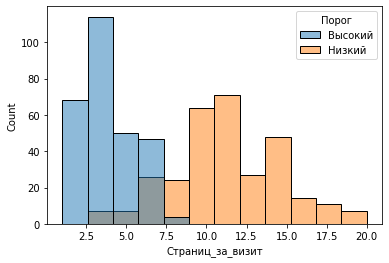

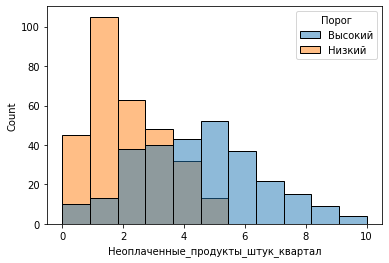

In [53]:
segment_columns = ['предыдущий_месяц_минуты', 
                   'Средний_просмотр_категорий_за_визит', 
                   'текущий_месяц_минуты', 
                   'Страниц_за_визит', 
                   'Неоплаченные_продукты_штук_квартал']

for column in segment_columns:
    sns.histplot(data=segment_market, x=column, hue='Порог')
    plt.show()

Средние значения всех столбцов, кроме `Неоплаченные_продукты_штук_квартал` - ниже у сегментов с клиентами со сниженной покупательской активностью. Чем меньше клиент провел времени на сайте - тем меньше вероятность что он приобрете что-либо.

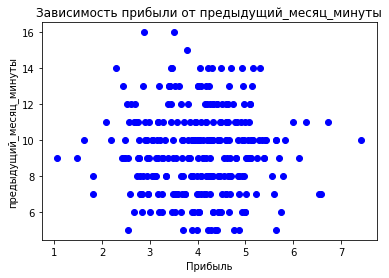

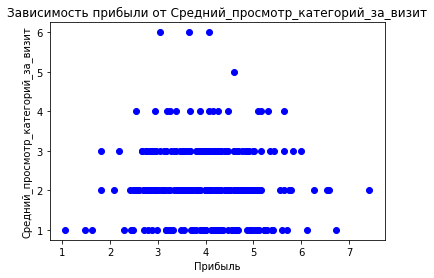

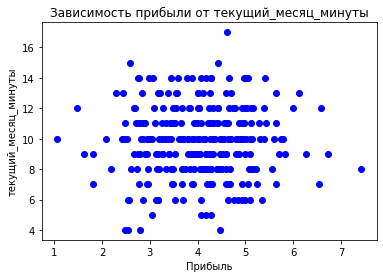

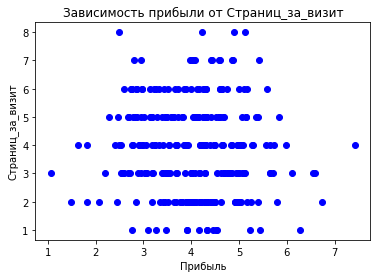

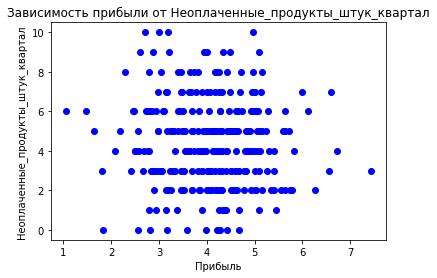

In [55]:
for column in segment_columns:
    plt.scatter(segment_market_threshold_high['Прибыль'], segment_market_threshold_high[column], color='blue', marker='o', label='Данные')
    plt.xlabel('Прибыль')
    plt.ylabel(column)
    plt.title(f'Зависимость прибыли от {column}')
    plt.show()

Можно заметить что прибыль на всех графиках собирается в основном на своих средних значениях по всей выборке. Так же около значения 4

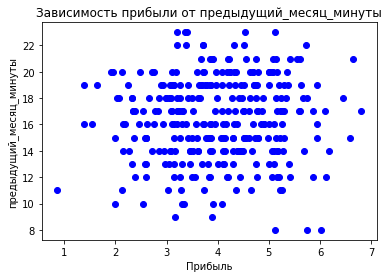

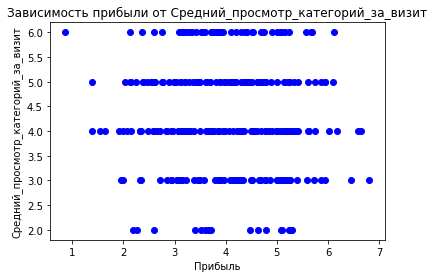

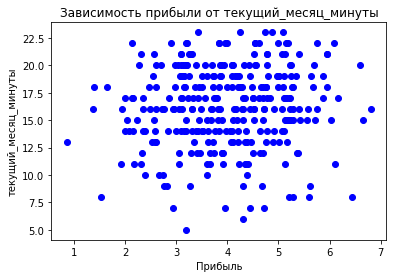

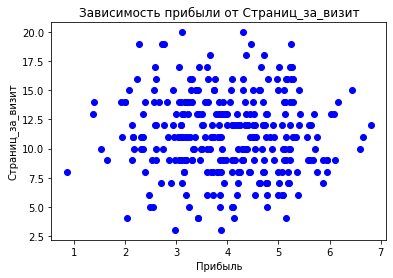

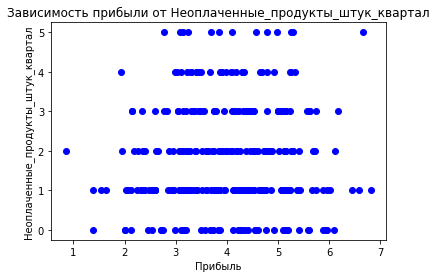

In [56]:
for column in segment_columns:
    plt.scatter(segment_market_threshold_low['Прибыль'], segment_market_threshold_low[column], color='blue', marker='o', label='Данные')
    plt.xlabel('Прибыль')
    plt.ylabel(column)
    plt.title(f'Зависимость прибыли от {column}')
    plt.show()

Хоть средние значения самих признаков довольно сильно отличаются - прибыльность при этом практически не изменилась.

### Выводы по сегментации

- Путем сегментации было выявлено что при низком показателе активности пользователя на сайте его покупательская активность снижается. Клиент реже заходит на сайт - следовательно реже делает покупки
- При небольшом количестве просматриваемых категорий - покупаетльская активность так же идет на спад. Скорее всего клиент пользуется услугами другого продавца, для покупки неиспользуемых категорий. Либо же клиент не заинтересован в других категориях вовсе.
- Чем больше у клиента неоплаченных покупок в корзине тем меньше покупательская активность. Возможно клиента не устраивает цена товара, поэтому он добавляет его в корзину в ожидании акционного предложения на него.

***Советы***

- Настроить систему рекомендаций на сайте, чтобы удержать клиента на нем как можно дольше. Предлагать похожие товары, или товары категорий, которые могут быть ему интересны
- Собрать больше данных о пользователях, чтобы понимать какие категории могут быть интересны - для таргетированной рекламы. Например сделать отдельные категории данных под клиентов с детьми или домашними питомцами. Это позволит предлагать клиентам товары из категорий, которые возможно они покупают на других сайтах
- Делать специальные предложения клиентам, на товары, которые находятся у них в корзинах. Однако делать это нужно с предельной осторожностью, чтобы все клиенты не начали добавлять товары в корзину в ожидании скидок.

## Шаг 9. Общий вывод

В ходе выполнения исследования были выполнены следующие действия:

1. Загрузка и предобработка данных


2. Исследовательский анализ данных, в ходе которого:
    - было исследовано распределение данных
    - произведен поиск аномалий в данных
    - произведен корреляционный анализ признаков
    
    
3. Создание пайплайна для поиска лучшей модели предсказания целевого признака


4. Найдена лучшая модель, ей оказалась:
    - модель LogisticRegression со следующими параметрами
        - C=10000
        - class_weight='balanced' 
        - l1_ratio=0.25 
        - solver='saga' 
        
5. Произведен анализ важности признаков, в ходе которого были найдены самые значимые из них, а именно:
    - предыдущий_месяц_минуты
    - Средний_просмотр_категорий_за_визит
    - текущий_месяц_минуты 
    - Страниц_за_визит
    - Неоплаченные_продукты_штук_квартал
    
    
6. Даны советы для заказчика:

    - Настроить систему рекомендаций на сайте, чтобы удержать клиента на нем как можно дольше. Предлагать похожие товары, или товары категорий, которые могут быть ему интересны
    - Собрать больше данных о пользователях, чтобы понимать какие категории могут быть интересны - для таргетированной рекламы. Например сделать отдельные категории данных под клиентов с детьми или домашними питомцами. Это позволит предлагать клиентам товары из категорий, которые возможно они покупают на других сайтах
    - Делать специальные предложения клиентам, на товары, которые находятся у них в корзинах. Однако делать это нужно с предельной осторожностью, чтобы все клиенты не начали добавлять товары в корзину в ожидании скидок.